# Imoport Data

## HLE-R1

In [ ]:
import pandas as pd

file_path = 'df_HLE_r1_final.jsonl'
df_HLE_r1 = pd.read_json(file_path, lines=True)
df_HLE_r1_filtered = df_HLE_r1[df_HLE_r1['LLM_Grade'] == df_HLE_r1['grade']]
df_HLE_r1_filtered['reasoning_length']=df_HLE_r1_filtered['reasoning'].str.split().str.len()

## HLE-Claude

In [ ]:
file_path = 'df_HLE_Claude_final.jsonl'
df_HLE_Claude = pd.read_json(file_path, lines=True)
df_HLE_Claude['reasoning_length']=df_HLE_Claude['reasoning'].str.split().str.len()

df_HLE_Claude_filtered = df_HLE_Claude[df_HLE_Claude['LLM_Grade'] == df_HLE_Claude['grade']]

## Omni-R1

In [ ]:
file_path = 'df_omni_math_r1_final.jsonl'
df_omni_math_r1 = pd.read_json(file_path, lines=True)
df_omni_math_r1['reasoning_length']=df_omni_math_r1['reasoning'].str.split().str.len()


## Omni-Claude

In [ ]:
file_path = 'df_omni_math_Claude_final.jsonl'
df_omni_math_Claude = pd.read_json(file_path, lines=True)
df_omni_math_Claude['reasoning_length']=df_omni_math_Claude['reasoning'].str.split().str.len()

# Hedging function Used Example

In [ ]:
import re

# Define regex patterns for hedging
hedging_patterns = [
    r'\b(might|may|could|should|would|seems|suggests|appears)\b',  # Modal verbs + additional verbs from the set
    r'\b(possibly|perhaps|likely|unlikely|probably|generally|usually|sometimes|often|tends|somewhat|rather|quite|almost|nearly|virtually|presumably|arguably|relatively|fairly|reasonably|mostly|partially|mainly|primarily|essentially|basically)\b',  # Adverbs
    r'\b(it seems that|it appears that|it suggests that|it is possible that|it is likely that)\b',  # Phrases
    r'\b(in part|to some extent)\b'  # Other hedging phrases
]

# Combine patterns into a single regex
hedging_regex = re.compile('|'.join(hedging_patterns), re.IGNORECASE)

def detect_hedging_regex(text, hedging_regex):
    """
    Detects hedging in a text using regex patterns.
    Returns the count of hedging instances normalized by the number of words and a list of detected hedging terms.
    """
    if not isinstance(text, str):
        return 0, []
    # Find all matches of hedging patterns
    matches = hedging_regex.findall(text)
    
    # Flatten the list of matches (regex returns tuples for multiple groups)
    matches = [match for sublist in matches for match in sublist if match]
    
    # Normalize by the number of words in the text
    word_count = len(text.split())
    normalized_count = len(matches) / word_count if word_count > 0 else 0
    
    # Return the normalized count of hedging instances and the list of detected terms
    return normalized_count, matches

# Apply the hedging detection function to the 'answerLLM' and 'reasoning' columns
#df_omni_math_Claude['hedging_count_R'], df_omni_math_Claude['hedging_terms_R'] = zip(*df_omni_math_Claude['reasoning'].apply(lambda x: detect_hedging_regex(x, hedging_regex)))

# Batch Calls Examples

## Full example Emotion API R1 and GPT

In [ ]:
import json

# Define the output file path
output_file_path = 'df_HLE_r1_Emotion_Vec.jsonl'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    # Iterate over each row in the DataFrame
    for index, row in df_HLE_r1.iterrows():
        # Create a dictionary with the reasoning
        data = {'reasoning': row['reasoning']}
        # Write the dictionary as a JSON object to the file
        file.write(json.dumps(data) + '\n')

print(f"JSONL file created at: {output_file_path}")

In [ ]:
import json
from openai import OpenAI
   

def prepare_batch_file(output_file, data_file):
    with open(output_file, 'w') as new_file:
        with open(data_file, 'r') as file:
            for index, line in enumerate(file):
                json_object = json.loads(line)
                prompt = f"""
                Judge how emotional this text is by reporting on its most positive emotion and its most negative emotion on a scale from -1 (negative) to 1 (positive), and the order in which they appear, i.e. direction in which they appear, if the most negative emotion appears before the most positive emotion the direction is upward so 1 if inverse is true the direction is -1 if the text is completely neutral and no gradient exists present between the two emotional extremes the direction is 0, picking up on small effects.
                Always end your response with:
                Most positive emotion Score: ...
                Most negative emotion Score: ...
                Direction: ...
                {json_object["reasoning"]}
                """
                payload = {
                    "custom_id":f"custom_id_{index}",
                    "method": "POST",
                    "url": "/v1/chat/completions",
                    "body": { 
                         "model": "o3-mini",
                         "messages": [
                            {"role": "user", "content": prompt}
                         ],
                         "max_completion_tokens": 100000
                     }
                }
                new_file.write(json.dumps(payload) + '\n')


output_file = 'batch_file_o3_HLE_r1_EmoVec.jsonl'
data_file = 'df_HLE_r1_Emotion_Vec.jsonl'

prepare_batch_file(output_file, data_file)

### Call API

In [ ]:
client = OpenAI(api_key="your_key_here")

batch_input_file = client.files.create(
  file=open("batch_file_o3_HLE_r1_EmoVec.jsonl", "rb"),
  purpose="batch"
)

batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "reasoning emotion analysis pos and neg"
    }
)


## Getting Answers Claude

In [ ]:
import json

# Define the output file path
output_file_path = 'df_HLE_Claude.jsonl'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    # Iterate over each row in the DataFrame
    for index, row in df_HLE_Claude.iterrows():
        # Create a dictionary with the reasoning
        data = {'question': row['question']}
        # Write the dictionary as a JSON object to the file
        file.write(json.dumps(data) + '\n')

print(f"JSONL file created at: {output_file_path}")

In [ ]:
import json

# System prompt to guide Claude's responses
SYSTEM_PROMPT = """Your response should be in the following format:
Explanation: {your explanation for your final answer}
Exact Answer: {your succinct, final answer}
Confidence: {your confidence score between 0% and 100% for your answer}"""

# Prepare the data in the correct format for the Claude Batch API
def prepare_batch_file_claude(output_file, data_file):
    with open(data_file, 'r') as file, open(output_file, 'w') as new_file:
        for index, line in enumerate(file):
            json_object = json.loads(line)
            prompt = f"""Solve the following problem. {json_object['question']}"""

            # Create a properly formatted request object
            batch_request = {
                "custom_id": f"request_{index}",
                "params": {
                    "model": "claude-3-7-sonnet-20250219",
                    "max_tokens": 128_000,
                    "system": SYSTEM_PROMPT,
                    "messages": [
                        {
                            "role": "user",
                            "content": prompt
                        }
                    ],
                    "thinking": {
                        "type": "enabled",
                        "budget_tokens": 100_000
                        }
                        }
            }

            
            # Write each request as a separate JSON line
            new_file.write(json.dumps(batch_request) + "\n")

# Define input and output files
output_file = 'batch_file_claude_HLE_completions.jsonl'
data_file = 'df_HLE_Claude.jsonl'

# Generate the batch file
prepare_batch_file_claude(output_file, data_file)


### Launch API

In [ ]:
client = OpenAI(api_key="your_key_here")

#batch_input_file = client.files.create(
  file=open("batch_file_o3_HLE_r1_EmoVec.jsonl", "rb"),
  purpose="batch"
)

batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "reasoning emotion analysis pos and neg"
    }
)


## Grading with Omni Judge

In [ ]:
import json
import requests
from tqdm import tqdm

def get_response(question, reference_answer, student_solution):
    content = "**Question**:\n{}\n\n**Reference Answer**\n{}\n\n**Student Solution**:\n{}\n\n"
    prompt = content.format(
        question.strip(),
        reference_answer.strip(),
        student_solution.strip(),
    )
    messages = [
        {
            "role": "system",
            "content": "You are an experienced teacher in the field of MATHEMATICS."
        },
        {
            "role": "user",
            "content": "# OBJECTIVE #\nYou are tasked with evaluating the correctness of a student's answer. Below, you are provided with a problem, a reference answer, and a student's answer. You should assess whether the student's answer captures the same meaning as the reference answer, even when expressed with different wording or format.\n\nYour tasks include:\nA. Identify Mathematical or Notational Equivalence.\nB. Conclude with a brief explanation as to why the student's output is correct or incorrect.\n\n# RESPONSE: MARKDOWN REPORT #\n## Student Final Answer\n[Extract the student's final answer, which is enclosed in \"\\\\boxed{}\".]\n## Equivalence Judgement\n[Whether the student's answer share the same meaning with the reference answer. (TRUE or FALSE)]\n## Justification\n[Conclude with a brief explanation as to why the student's answer is correct or incorrect.]\n\n\n# ATTENTION #\n - The reference answer is ALWAYS correct. You should carefully judge whether the student gives the same answer as reference answer.\n - The answer is FALSE even if the student's final answer is almost correct with a minor mistakes.\n - The answer is contained within the \"boxed\" section, so you can focus solely on comparing the content in the student's answer box with the reference answer, without needing to consider the intermediate steps.\n - Add \"=== report over ===\" at the end of the report."
        },
        {
            "role": "assistant",
            "content": "OK."
        },
        {
            "role": "user",
            "content": prompt
        }
    ]
    payload = {
        "model": "kbsdjames.omni-judge",
        "messages": messages,
        "max_new_tokens": 300
    }
    response = requests.post(
        "http://127.0.0.1:1234/v1/chat/completions",
        headers={"Content-Type": "application/json"},
        data=json.dumps(payload)
    )
    return response.json()['choices'][0]['message']['content']

def judge_4o(f_modelsolutions, output_file):
    with open(f_modelsolutions, "r") as infile:
        total_questions = sum(1 for _ in infile)

    with open(f_modelsolutions, "r") as infile:
        with open(output_file, 'w') as outputfile:
            for line in tqdm(infile, total=total_questions, desc="Processing questions", unit="questions"):
                entry = json.loads(line)
                response = get_response(entry["problem"], entry["answer"], entry["answerLLM"])
                payload = {
                    "domain": entry["domain"],
                    "difficulty": entry["difficulty"],
                    "problem": entry["problem"],
                    "answer": entry["answer"],
                    "model_generation": entry["answerLLM"],
                    "omni-judge": response,
                    "source": entry["source"]
                }
                outputfile.write(json.dumps(payload) + '\n')

output_file = "omni.jsonl"
judge_4o('df_omni.jsonl', output_file)


# Creating Lexicon

In [309]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [310]:
dataset_avg_accuracies = {
    'HLE_r1': df_HLE_r1_filtered['grade'].mean(),
    'HLE_Claude': df_HLE_Claude_filtered['grade'].mean(),
    'Omni_r1': df_omni_math_r1['grade'].mean(),
    'Omni_Claude': df_omni_math_Claude['grade'].mean()
}


In [311]:
import numpy as np
import scipy.stats as st
import re
from collections import defaultdict

def bootstrap_relative_accuracy(correct, total, dataset_mean, n_boot=1000):
    if total == 0 or dataset_mean == 0:
        return np.nan, np.nan
    boot_acc = np.random.binomial(total, correct / total, n_boot) / total
    boot_rel = boot_acc / dataset_mean
    ci_low, ci_high = np.percentile(boot_rel, [2.5, 97.5])
    return ci_low, ci_high

def build_cot_lexicon_by_dataset(
    dfs,
    df_names,
    cot_col='reasoning',
    grade_col='grade',
    lowercase=True,
    min_occurrences=10,
    ci_level=0.95,
    n_boot=1000  # Number of bootstrap draws
):
    dataset_avg_accuracies = {
        name: df[grade_col].mean()
        for df, name in zip(dfs, df_names)
    }
    z = st.norm.ppf(1 - (1 - ci_level) / 2)

    word_stats = defaultdict(lambda: defaultdict(lambda: {'correct': 0, 'incorrect': 0}))

    for df, name in zip(dfs, df_names):
        for _, row in df.iterrows():
            cot = row[cot_col]
            correct = row[grade_col]
            if isinstance(cot, str):
                words = re.findall(r'\b\w+\b', cot)
                if lowercase:
                    words = [w.lower() for w in words]
                unique_words = set(words)
                for word in unique_words:
                    if correct:
                        word_stats[word][name]['correct'] += 1
                    else:
                        word_stats[word][name]['incorrect'] += 1

    rows = []
    for word, dataset_stats in word_stats.items():
        row = {'word': word}
        keep_word = True
        for name in df_names:
            correct = dataset_stats[name]['correct']
            incorrect = dataset_stats[name]['incorrect']
            total = correct + incorrect
            if total >= min_occurrences:
                p_hat = correct / total
                se = (p_hat * (1 - p_hat) / total) ** 0.5
                ci_low = p_hat - z * se
                ci_high = p_hat + z * se

                avg_acc = dataset_avg_accuracies[name]
                rel_acc = p_hat / avg_acc if avg_acc > 0 else np.nan

                # Use bootstrap for relative accuracy CI
                rel_ci_low, rel_ci_high = bootstrap_relative_accuracy(correct, total, avg_acc, n_boot=n_boot)

                row[f'{name}_accuracy'] = p_hat
                row[f'{name}_count'] = total
                row[f'{name}_accuracy_ci_low'] = max(0, ci_low)
                row[f'{name}_accuracy_ci_high'] = min(1, ci_high)
                row[f'{name}_relative_accuracy'] = rel_acc
                row[f'{name}_relative_accuracy_ci_low'] = rel_ci_low
                row[f'{name}_relative_accuracy_ci_high'] = rel_ci_high
            else:
                keep_word = False
                break
        if keep_word:
            rows.append(row)

    df_lexicon = pd.DataFrame(rows)
    rel_cols = [f'{name}_relative_accuracy' for name in df_names]
    df_lexicon['mean_relative_accuracy'] = df_lexicon[rel_cols].mean(axis=1)
    df_lexicon = df_lexicon.sort_values(by='mean_relative_accuracy', ascending=False).reset_index(drop=True)
    return df_lexicon


In [312]:
def lemmatize_and_merge(lexicon_df, df_names, dataset_avg_accuracies, min_occurrences=300, lowercase=True):
    # 1. Manual exclusions to preserve critical words
    manual_exclusions = {
        'stuck': 'stuck',
        'better': 'better',
        'best': 'best',
        'yes': 'yes',
        'satisfies': 'satisfy'
       # 'reconsider': 'reconsider'
        # Add more words as needed where lemmatization distorts meaning
    }

    # 2. Custom lemmatization function
    def custom_lemmatize(word):
        word_lc = word.lower() if lowercase else word
        if word_lc in manual_exclusions:
            return manual_exclusions[word_lc]
        if word_lc == "ll":
            return "will"
        if word_lc == "ve":
            return "have"
        doc = nlp(word)
        lemmas = [token.lemma_ for token in doc if token.is_alpha]
        return lemmas[0].lower() if lowercase and lemmas else word_lc

    lexicon_df = lexicon_df.copy()
    lexicon_df['lemma'] = lexicon_df['word'].apply(custom_lemmatize)

    # 3. Group by lemma and sum counts
    sum_cols = [f'{name}_count' for name in df_names]
    acc_cols = [f'{name}_accuracy' for name in df_names]

    grouped = lexicon_df.groupby('lemma')

    merged_data = []
    for lemma, group in grouped:
        row = {'lemma': lemma}

        for name in df_names:
            count_col = f'{name}_count'
            acc_col = f'{name}_accuracy'

            total_count = group[count_col].sum()
            total_correct = (group[acc_col] * group[count_col]).sum()

            if total_count >= min_occurrences:
                accuracy = total_correct / total_count
            else:
                accuracy = np.nan  # Not enough data

            row[count_col] = total_count
            row[acc_col] = accuracy
            row[f'{name}_relative_accuracy'] = accuracy / dataset_avg_accuracies[name] if not np.isnan(accuracy) else np.nan

        merged_data.append(row)

    merged = pd.DataFrame(merged_data)

    # 4. Drop incomplete rows
    merged.dropna(inplace=True)

    # 5. Compute mean and std of relative accuracy
    rel_cols = [f'{name}_relative_accuracy' for name in df_names]
    merged['mean_relative_accuracy'] = merged[rel_cols].mean(axis=1)
    merged['std_relative_accuracy'] = merged[rel_cols].std(axis=1)

    # 6. Consistency flags
    merged['consistently_helpful'] = merged[rel_cols].gt(1.0).all(axis=1)
    merged['consistently_harmful'] = merged[rel_cols].lt(1.0).all(axis=1)

    # 7. Sort
    merged = merged.sort_values(by='mean_relative_accuracy', ascending=False).reset_index(drop=True)

    return merged


In [313]:
dfs = [
    df_HLE_r1_filtered,
    df_HLE_Claude_filtered,
    df_omni_math_r1,
    df_omni_math_Claude
]

df_names = ['HLE_r1', 'HLE_Claude', 'Omni_r1', 'Omni_Claude']

lexicon_df = build_cot_lexicon_by_dataset(
    dfs,
    df_names,
    cot_col='reasoning',
    grade_col='grade',
    min_occurrences=300
)


accuracy_cols = [f'{name}_relative_accuracy' for name in df_names]
lexicon_df['std_relative_accuracy'] = lexicon_df[accuracy_cols].std(axis=1)
lexicon_df['consistently_helpful'] = lexicon_df[accuracy_cols].gt(1.0).all(axis=1)
lexicon_df['consistently_harmful'] = lexicon_df[accuracy_cols].lt(1.0).all(axis=1)



lemmatized_lexicon = lemmatize_and_merge(
    lexicon_df,
    df_names,
    dataset_avg_accuracies,
    min_occurrences=300
)

for name in df_names:
    count_col = f"{name}_count"
    acc_col = f"{name}_accuracy"
    avg_acc = dataset_avg_accuracies[name]
    z = 1.96  # 95% CI
    accuracy = lemmatized_lexicon[acc_col]
    count = lemmatized_lexicon[count_col]
    se = np.sqrt(accuracy * (1 - accuracy) / count)
    ci_low = accuracy - z * se
    ci_high = accuracy + z * se
    lemmatized_lexicon[f"{name}_accuracy_ci_low"] = np.clip(ci_low, 0, 1)
    lemmatized_lexicon[f"{name}_accuracy_ci_high"] = np.clip(ci_high, 0, 1)
    lemmatized_lexicon[f"{name}_relative_accuracy_ci_low"] = lemmatized_lexicon[f"{name}_accuracy_ci_low"] / avg_acc
    lemmatized_lexicon[f"{name}_relative_accuracy_ci_high"] = lemmatized_lexicon[f"{name}_accuracy_ci_high"] / avg_acc




In [314]:
number_words = {
    "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten",
    "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen",
    "eighteen", "nineteen", "twenty", "thirty", "forty", "fifty", "sixty", "seventy",
    "eighty", "ninety", "hundred", "thousand", "million", "billion", "trillion"
}
    # Remove numbers and 1-character words/lemma    
lemmatized_lexicon = lemmatized_lexicon[
        lemmatized_lexicon['lemma'].apply(lambda w: len(w) > 1 and not w.isdigit() and w.lower() not in number_words)]# and not w == "satisfie")]

In [315]:
import matplotlib.pyplot as plt
import seaborn as sns

pretty_names = {
    "HLE_r1": "HLE–DeepSeek-R1",
    "HLE_Claude": "HLE–Claude",
    "Omni_r1": "OmniMath–DeepSeek-R1",
    "Omni_Claude": "OmniMath–Claude"
}

def plot_lexicon_relative_accuracy(
    lexicon_df,
    df_names,
    top_n=50,
    palette=None
):
    if palette is None:
        # Fallback palette if not passed
        palette = {
            "HLE_r1": "#4C72B0",
            "HLE_Claude": "#DD8452",
            "Omni_r1": "#55A868",
            "Omni_Claude": "#C44E52"
        }

    accuracy_cols = [f'{name}_relative_accuracy' for name in df_names]
    top_df = lexicon_df.head(top_n).copy()
    bottom_df = lexicon_df.tail(top_n).copy()

    def plot_subset(subset_df, title):
        accuracy_cols = [f'{name}_relative_accuracy' for name in df_names]
        ci_low_cols = [f'{name}_relative_accuracy_ci_low' for name in df_names]
        ci_high_cols = [f'{name}_relative_accuracy_ci_high' for name in df_names]

        melted = subset_df.melt(
            id_vars=['lemma', 'mean_relative_accuracy', 'std_relative_accuracy', 'consistently_helpful', 'consistently_harmful'],
            value_vars=accuracy_cols,
            var_name='Dataset',
            value_name='Relative Accuracy'
        )
        melted_ci_low = subset_df.melt(
            id_vars=['lemma'],
            value_vars=ci_low_cols,
            var_name='Dataset',
            value_name='ci_low'
        )
        melted_ci_high = subset_df.melt(
            id_vars=['lemma'],
            value_vars=ci_high_cols,
            var_name='Dataset',
            value_name='ci_high'
        )
        melted['Dataset'] = melted['Dataset'].str.replace('_relative_accuracy', '')
        melted_ci_low['Dataset'] = melted_ci_low['Dataset'].str.replace('_relative_accuracy_ci_low', '')
        melted_ci_high['Dataset'] = melted_ci_high['Dataset'].str.replace('_relative_accuracy_ci_high', '')
        melted['ci_low'] = melted_ci_low['ci_low']
        melted['ci_high'] = melted_ci_high['ci_high']

        plt.figure(figsize=(16, 8))
        ax = sns.barplot(
            data=melted,
            x='lemma',
            y='Relative Accuracy',
            hue='Dataset',
            palette=palette,
            dodge=True,
            alpha=0.9
        )

        # Draw CI rectangles in front of each bar
        for bar, (_, row) in zip(ax.patches, melted.iterrows()):
            x = bar.get_x()
            width = bar.get_width()
            y_bottom = row['ci_low']
            y_top = row['ci_high']
            ax.add_patch(
                plt.Rectangle(
                    (x, y_bottom),
                    width,
                    y_top - y_bottom,
                    fill=False,
                    edgecolor='black',
                    linewidth=1.2,
                    linestyle='-',
                    zorder=10,
                    alpha=1,
                )
            )

        # Plot mean relative accuracy as black dots
        xticks = ax.get_xticks()
        ax.scatter(
            xticks, subset_df['mean_relative_accuracy'],
            color='black', s=40, label='Mean Relative Accuracy', zorder=20
        )

        # Optionally, make main bars more visible
        for bar in ax.patches:
            bar.set_alpha(0.9)
            bar.set_linewidth(1.1)
            bar.set_edgecolor('black')
        
        # Highlight consistent performers
        tick_labels = ax.get_xticklabels()
        for idx, label in enumerate(tick_labels):
            if idx < len(subset_df):
                row = subset_df.iloc[idx]
                if row['consistently_helpful']:
                    label.set_color('green')
                    label.set_fontweight('bold')
                elif row['consistently_harmful']:
                    label.set_color('red')
                    label.set_fontweight('bold')

        ax.set_title(title, fontsize=16, fontweight='bold')
        ax.set_xlabel('Lemmatized Words', fontsize=18, fontweight='bold')
        ax.set_ylabel('Relative Accuracy', fontsize=18, fontweight='bold')
        ax.set_ylim([0, 2])
        ax.set_xticklabels(subset_df['lemma'], rotation=45, ha='right',fontsize=16)
        ax.tick_params(axis='y', labelsize=16) 
        ax.axhline(1.0, linestyle='--',linewidth=2 ,color='black', label='Baseline (Dataset Mean)')
        handles, labels = ax.get_legend_handles_labels()
        labels = [pretty_names.get(label, label) for label in labels]
        ax.legend(handles, labels, fontsize=16)
        plt.tight_layout()
        plt.show()

    plot_subset(top_df,'')#, f'Top {top_n} Words by Relative Accuracy')
    plot_subset(bottom_df,'')#, f'Bottom {top_n} Words by Relative Accuracy')


/var/folders/n6/zmvcqpjn0l946jfs0rcg1wfh0000gn/T/ipykernel_66070/332843741.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset_df['lemma'], rotation=45, ha='right',fontsize=16)


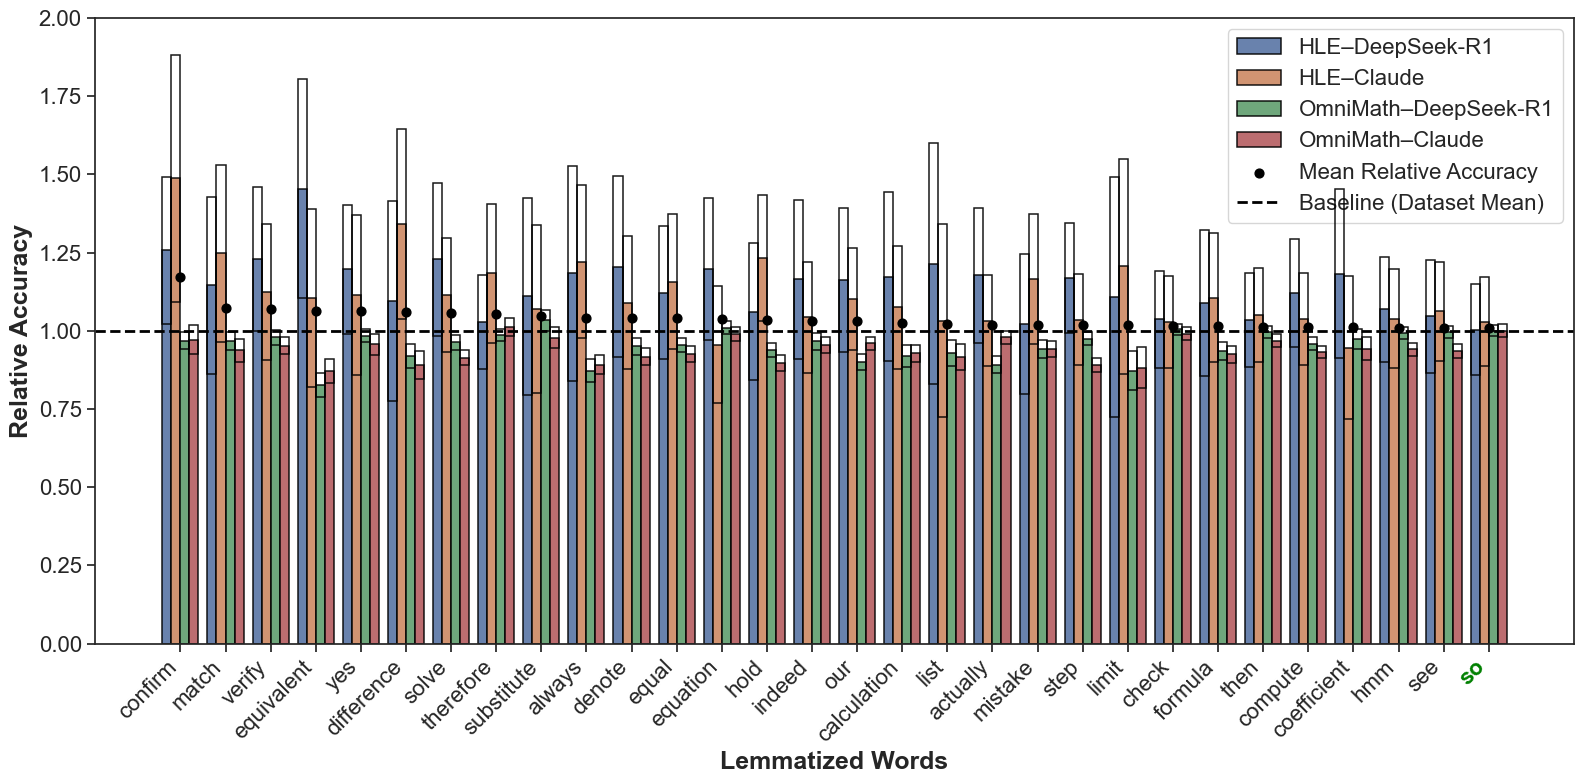

/var/folders/n6/zmvcqpjn0l946jfs0rcg1wfh0000gn/T/ipykernel_66070/332843741.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset_df['lemma'], rotation=45, ha='right',fontsize=16)


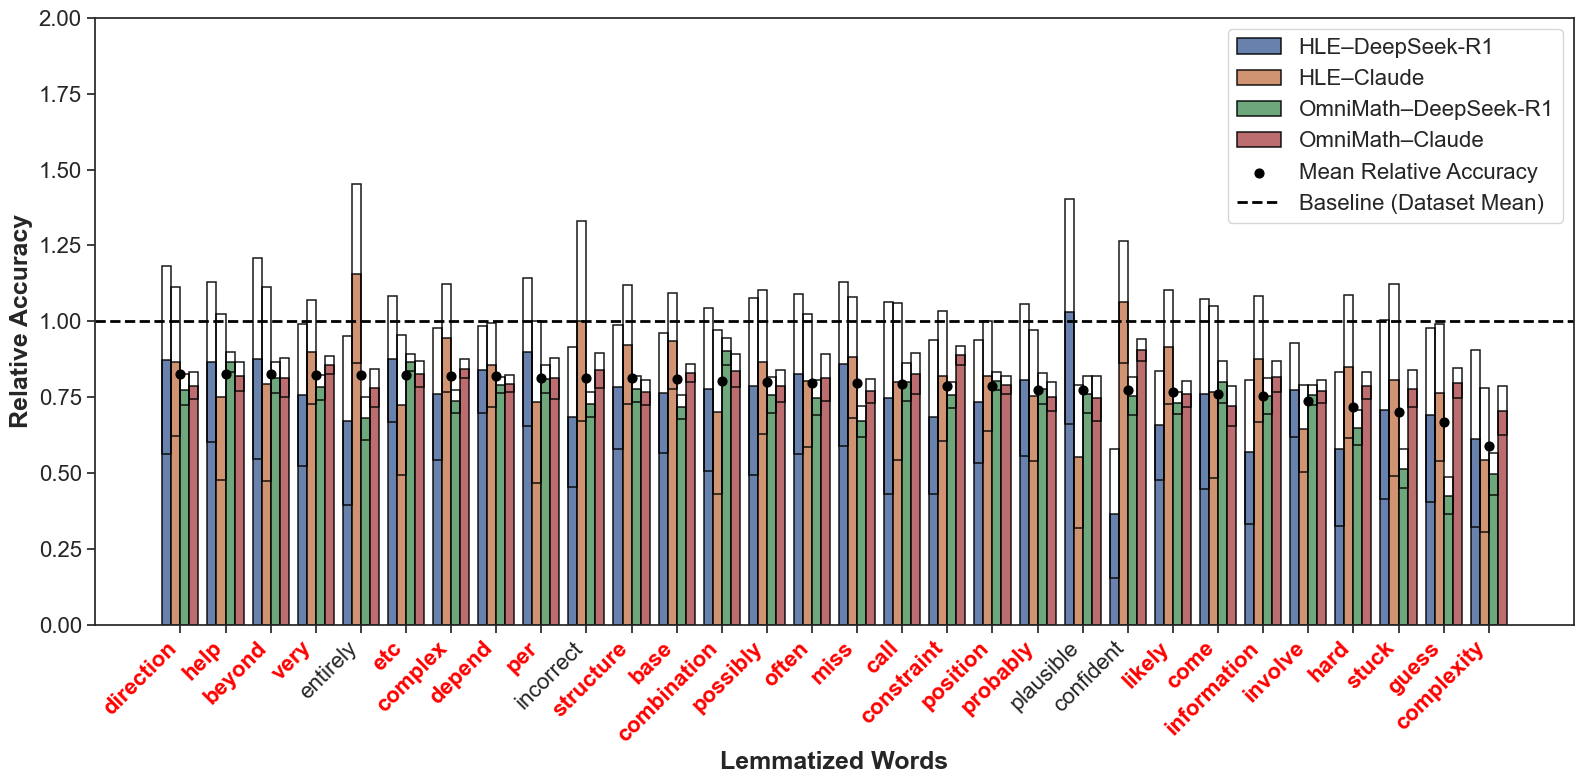

In [316]:
plot_lexicon_relative_accuracy(lemmatized_lexicon, df_names, top_n=30)

# Neural Networks

In [317]:
# Select 25 worst consistently harmful words
worst_consistent_words = (
    lexicon_df[lexicon_df['consistently_harmful']]
    .sort_values(by='mean_relative_accuracy')
    .head(25)['word']
    .tolist()
)

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

def extract_features(
    dfs,
    df_names,
    words,
    cot_col='reasoning',
    grade_col='grade',
    feature_vector=[
        'counts',
        'reasoning_length',
        'emotion_diff',
        'confidence',
        'hedging_count'
    ]
):
    features = []
    labels = []
    origins = []

    print(f"Extracting features for {len(words)} words across {len(dfs)} datasets...")
    
    for df, name in zip(dfs, df_names):
        # Precompute denominator for relative_length (if present)
        if 'relative_length' in feature_vector:
            if 'problem_length' in df.columns:
                denom = df['problem_length']
            else:
                denom = np.ones(len(df))
        for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {name}"):
            cot = row.get(cot_col, "")
            grade = row.get(grade_col, 0)
            feats = []
            
            # 1. Word counts
            if 'counts' in feature_vector:
                if isinstance(cot, str):
                    tokens = cot.lower().split()
                    counts = [tokens.count(word) for word in words]
                else:
                    counts = [0] * len(words)
                feats.extend(counts)
            
            
            
            # 2. Reasoning length
            if 'reasoning_length' in feature_vector:
                feats.append(len(cot.split()) if isinstance(cot, str) else 0)
            
            # 3. Emotion_Difference
            if 'emotion_diff' in feature_vector:
                feats.append(row.get('Emotion_Difference', 0))
            
            # 4. Confidence (if present)
            if 'confidence' in feature_vector:
                feats.append(row.get('confidence', 0))
            
            
            # 5. Hedging count per sentence
            if 'hedging_count' in feature_vector:
                feats.append(row.get('hedging_count_R_sentence', 0))

            features.append(feats)
            labels.append(int(grade))
            origins.append(name)
    
    X = np.array(features)
    y = np.array(labels)
    origins = np.array(origins)
    return X, y, origins


In [ ]:
feature_vector = [
    #'counts', #words vector
    'reasoning_length',
    'emotion_diff',
    'confidence',
    'hedging_count'
]

X, y, origins = extract_features(
    dfs=[df_HLE_r1_filtered, df_HLE_Claude_filtered, df_omni_math_r1, df_omni_math_Claude],
    df_names=['HLE_r1', 'HLE_Claude', 'Omni_r1', 'Omni_Claude'],
    words=worst_consistent_words,
    cot_col='reasoning',
    grade_col='grade',
    feature_vector=feature_vector
)


In [ ]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import os

def set_all_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)


def train_balanced_nn(X, y, dataset_name, verbose_eval=True, seed=42):

    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}
    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X = X[mask]
    y = y[mask]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=seed
    )
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X.shape[1],)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=256,
        validation_split=0.2,
        verbose=0,
        class_weight=class_weight_dict
    )
    if verbose_eval:
        y_pred = (model.predict(X_test) >= 0.5).astype(int)
        print(f"\nClassification Report for {dataset_name}:")
        print(classification_report(y_test, y_pred, target_names=["Incorrect (0)", "Correct (1)"]))
    return model, history

def balance_data(X, y, random_state=123):
    np.random.seed(random_state)
    y = np.asarray(y)
    classes = np.unique(y)
    idxs_0 = np.where(y == classes[0])[0]
    idxs_1 = np.where(y == classes[1])[0]
    n_min = min(len(idxs_0), len(idxs_1))
    idxs_0_bal = np.random.choice(idxs_0, n_min, replace=False)
    idxs_1_bal = np.random.choice(idxs_1, n_min, replace=False)
    idxs_bal = np.concatenate([idxs_0_bal, idxs_1_bal])
    np.random.shuffle(idxs_bal)
    X_bal = X[idxs_bal]
    y_bal = y[idxs_bal]
    return X_bal, y_bal

def run_nn_experiment(X_hle, y_hle, X_omni, y_omni, seed):
    set_all_seeds(seed)
    X_hle_train, X_hle_test, y_hle_train, y_hle_test = train_test_split(
        X_hle, y_hle, test_size=0.2, random_state=seed, stratify=y_hle)
    X_omni_train, X_omni_test, y_omni_train, y_omni_test = train_test_split(
        X_omni, y_omni, test_size=0.2, random_state=seed, stratify=y_omni)
    model_hle, _ = train_balanced_nn(X_hle_train, y_hle_train, f"HLE_seed{seed}", verbose_eval=False, seed=seed)
    model_omni, _ = train_balanced_nn(X_omni_train, y_omni_train, f"OmniMath_seed{seed}", verbose_eval=False, seed=seed)
    X_hle_bal_eval, y_hle_bal_eval = balance_data(X_hle_test, y_hle_test, random_state=seed)
    X_omni_bal_eval, y_omni_bal_eval = balance_data(X_omni_test, y_omni_test, random_state=seed)

    # Cache all predictions up front
    pred_hle_on_hle   = model_hle.predict(X_hle_bal_eval).ravel()
    pred_hle_on_omni  = model_hle.predict(X_omni_bal_eval).ravel()
    pred_omni_on_omni = model_omni.predict(X_omni_bal_eval).ravel()
    pred_omni_on_hle  = model_omni.predict(X_hle_bal_eval).ravel()

    accs = {}
    accs['hle_on_hle'] = accuracy_score(y_hle_bal_eval, (pred_hle_on_hle >= 0.5).astype(int))
    accs['hle_on_omni'] = accuracy_score(y_omni_bal_eval, (pred_hle_on_omni >= 0.5).astype(int))
    accs['omni_on_omni'] = accuracy_score(y_omni_bal_eval, (pred_omni_on_omni >= 0.5).astype(int))
    accs['omni_on_hle'] = accuracy_score(y_hle_bal_eval, (pred_omni_on_hle >= 0.5).astype(int))

    roc_data = {
        "hle_on_hle": (y_hle_bal_eval, pred_hle_on_hle),
        "hle_on_omni": (y_omni_bal_eval, pred_hle_on_omni),
        "omni_on_omni": (y_omni_bal_eval, pred_omni_on_omni),
        "omni_on_hle": (y_hle_bal_eval, pred_omni_on_hle)
    }
    return accs, roc_data




[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [ ]:
from sklearn.metrics import roc_curve
# Split the data by origin
mask_hle = np.isin(origins, ['HLE_r1', 'HLE_Claude'])
mask_omni = np.isin(origins, ['Omni_r1', 'Omni_Claude'])

X_hle, y_hle = X[mask_hle], y[mask_hle]
X_omni, y_omni = X[mask_omni], y[mask_omni]

# Clean NaNs
mask_hle = np.isin(origins, ['HLE_r1', 'HLE_Claude'])
mask_omni = np.isin(origins, ['Omni_r1', 'Omni_Claude'])

X_hle, y_hle = X[mask_hle], y[mask_hle]
X_omni, y_omni = X[mask_omni], y[mask_omni]

seeds = list(range(30))

# Set up result collectors
all_results = {k: [] for k in ['hle_on_hle', 'hle_on_omni', 'omni_on_omni', 'omni_on_hle']}
roc_results = {k: [] for k in all_results}
fpr_grid = np.linspace(0, 1, 101)  # For ROC interpolation

for seed in seeds:
    accs, roc_data = run_nn_experiment(X_hle, y_hle, X_omni, y_omni, seed)
    for k in all_results:
        all_results[k].append(accs[k])
        y_true, y_score = roc_data[k]
        mask = ~np.isnan(y_true) & ~np.isnan(y_score)
        y_true, y_score = y_true[mask], y_score[mask]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        interp_tpr = np.interp(fpr_grid, fpr, tpr)
        interp_tpr[0] = 0.0
        roc_results[k].append(interp_tpr)


In [ ]:
#reasoning length
import scipy.stats as st

def mean_ci(x):
    m = np.mean(x)
    se = st.sem(x)
    ci = se * st.t.ppf((1 + 0.95) / 2., len(x)-1)
    return m, m - ci, m + ci

summary = {}
for k, vals in all_results.items():
    m, low, high = mean_ci(vals)
    print(f"{k}: mean={m:.3f}, 95% CI=({low:.3f}, {high:.3f})")
    summary[k] = dict(mean=m, ci_low=low, ci_high=high, values=vals)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc

sns.set_theme(style='ticks', font_scale=1, rc={
    'axes.labelweight': 'bold',
    'axes.titlesize': 24,
    'axes.labelsize': 24,
    'legend.fontsize': 20,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
})


setting_order = ["hle_on_hle", "omni_on_omni", "hle_on_omni", "omni_on_hle"]
setting_labels = {
    "hle_on_hle": "HLE→HLE",
    "omni_on_omni": "Omni-Math→Omni-Math",
    "hle_on_omni": "HLE→Omni-Math",
    "omni_on_hle": "Omni-Math→HLE"
}
setting_colors = {
    "hle_on_hle": "#4C72B0",
    "omni_on_omni": "#DD8452",
    "hle_on_omni": "#55A868",
    "omni_on_hle": "#C44E52"
}

plt.figure(figsize=(8, 6))
for key in setting_order:
    tprs = np.array(roc_results[key])  # shape: (n_seeds, len(fpr_grid))
    mean_tpr = tprs.mean(axis=0)
    std_tpr = tprs.std(axis=0)
    ci_low = np.percentile(tprs, 2.5, axis=0)
    ci_high = np.percentile(tprs, 97.5, axis=0)
    auc_mean = auc(fpr_grid, mean_tpr)

    plt.plot(
        fpr_grid, mean_tpr, color=setting_colors[key], lw=2,
        label=f"{setting_labels[key]} (AUC={auc_mean:.2f})"
    )
    plt.fill_between(
        fpr_grid, ci_low, ci_high, color=setting_colors[key], alpha=0.18
    )

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.ylim(0,1)
plt.xlim(0,1)
plt.title('All', fontweight='bold', fontsize=24)
plt.legend(loc='lower right', fontsize=14)
plt.tight_layout()
plt.show()